In [0]:
!pip install pennylane

In [0]:
pip install pennylane-qchem

In [0]:
#import packages
import numpy as np
import pennylane as qml
from pennylane import expval, var, device

pi = np.pi

In [3]:
name ='LiH';charge = 0;multiplicity=1;basis= 'sto-3g';geometry = 'lih.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=3,
    n_active_electrons=2,
)
print(h, '\n', nr_qubits)

(-7.189117345981003) [I0]
+ (0.02498336736064769) [Z0]
+ (0.0048735920105351035) [Y0 Z1 Y2]
+ (0.0048735920105351035) [X0 Z1 X2]
+ (0.024983367360647678) [Z1]
+ (0.0048735920105351035) [Y1 Z2 Y3]
+ (0.0048735920105351035) [X1 Z2 X3]
+ (-0.13300290682418384) [Z2]
+ (-0.1330029068241838) [Z3]
+ (-0.1445363855022916) [Z4]
+ (-0.1445363855022916) [Z5]
+ (0.13106579035624258) [Z0 Z1]
+ (0.009702948635503639) [Y0 Y2]
+ (0.009702948635503639) [X0 X2]
+ (0.009702948635503639) [Z0 Y1 Z2 Y3]
+ (0.009702948635503639) [Z0 X1 Z2 X3]
+ (0.002366478148280204) [Y0 X1 X2 Y3]
+ (-0.002366478148280204) [Y0 Y1 X2 X3]
+ (-0.002366478148280204) [X0 X1 Y2 Y3]
+ (0.002366478148280204) [X0 Y1 Y2 X3]
+ (0.006795526682425653) [Y0 X1 X4 Y5]
+ (-0.006795526682425653) [Y0 Y1 X4 X5]
+ (-0.006795526682425653) [X0 X1 Y4 Y5]
+ (0.006795526682425653) [X0 Y1 Y4 X5]
+ (0.05929524181655196) [Z0 Z2]
+ (0.06166171996483217) [Z0 Z3]
+ (0.00034735301058658473) [Y0 Z1 Y2 Z3]
+ (0.00034735301058658473) [X0 Z1 X2 Z3]
+ (0.0048895

In [0]:
dev = qml.device("default.qubit", wires=6)
def ansatz(params, wires=[0,1,2,3,4,5]):
    for i in wires:
        qml.RY(params[i], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])
    for i in wires:
        qml.RY(params[i+6], wires=wires[i])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[4], wires[5]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[3], wires[4]])

initial_params = np.random.uniform(low=0, high=2*np.pi, size=12)

In [9]:
print(h.ops)

[<pennylane.operation.Tensor object at 0x7fa63633cc88>, <pennylane.operation.Tensor object at 0x7fa636318e10>, <pennylane.operation.Tensor object at 0x7fa63148ea20>, <pennylane.operation.Tensor object at 0x7fa600b2b7b8>, <pennylane.operation.Tensor object at 0x7fa600b2b940>, <pennylane.operation.Tensor object at 0x7fa600b2b9e8>, <pennylane.operation.Tensor object at 0x7fa600b2bb70>, <pennylane.operation.Tensor object at 0x7fa600b2bcf8>, <pennylane.operation.Tensor object at 0x7fa600b2bda0>, <pennylane.operation.Tensor object at 0x7fa600b2be48>, <pennylane.operation.Tensor object at 0x7fa600b2bef0>, <pennylane.operation.Tensor object at 0x7fa600b2bf98>, <pennylane.operation.Tensor object at 0x7fa5fd2aa0f0>, <pennylane.operation.Tensor object at 0x7fa5fd2aa208>, <pennylane.operation.Tensor object at 0x7fa5fd2aa320>, <pennylane.operation.Tensor object at 0x7fa5fd2aa518>, <pennylane.operation.Tensor object at 0x7fa5fd2aa710>, <pennylane.operation.Tensor object at 0x7fa5fd2aa908>, <pennylan

In [0]:
qnodes = qml.map(ansatz, h.ops, dev, measure='expval')
cost = qml.dot([h.coeffs], qnodes)

In [11]:
cost(initial_params)

array([-7.13693969])

In [0]:
fb_metric = qnodes[0].metric_tensor([initial_params], diag_approx=False)

In [13]:
max_iterations = 200
step_size = 0.05
conv_tol = 1e-06

optimizers = ['QNG', 'Vanilla']
QNG_cost = []
vanilla_cost = []


prev_energy = cost(initial_params)
for k in range(len(optimizers)):
    
    #Quantum Natural Gradient Descent
    if optimizers[k] == 'QNG':
        print("QUANTUM NATURAL GRADIENT")
        
        #initial params (example from Yamamoto 2019, FIG 5)
        params = initial_params
        
        for n in range(max_iterations):
            #compute the gradient
            gradient = qml.grad(cost, argnum=[0])
            
            #take the gradient of the params
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #perform quantum natural gradient.
            params = params - step_size * np.dot(np.linalg.pinv(fb_metric), grad_at_point)
            
            #compute new energy with updates params
            energy = cost(params)
            QNG_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if n % 20 == 0:
                print('Iteration = ', n,  'Ground-state energy = ', energy, 'Ha',  'Convergence parameter =', conv, 'Ha')

            if conv <= conv_tol:
                print("final params: ", params)
                break

            prev_energy = energy
            
    #Vanilla Gradient Descent
    if optimizers[k] == 'Vanilla':
        print("VANILLA GRADIENT")
        params = initial_params
        for n in range(max_iterations):
            
            gradient = qml.grad(cost, argnum=[0])
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #calculate vanilla gradient descent
            params = params - np.dot(step_size, grad_at_point)
            
            #calculate new energy with updates params
            energy = cost(params)
            vanilla_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if n % 1 == 0:
                print('Iteration = ', n,  'Ground-state energy = ', energy, 'Ha',  'Convergence parameter =', conv, 'Ha')

            if conv <= conv_tol:
                break

            prev_energy = energy

QUANTUM NATURAL GRADIENT
Iteration =  0 Ground-state energy =  [-7.1500036] Ha Convergence parameter = [0.01306391] Ha
Iteration =  20 Ground-state energy =  [-7.41177289] Ha Convergence parameter = [0.01040632] Ha
Iteration =  40 Ground-state energy =  [-7.53065609] Ha Convergence parameter = [0.00292319] Ha
Iteration =  60 Ground-state energy =  [-7.56261841] Ha Convergence parameter = [0.00089231] Ha
Iteration =  80 Ground-state energy =  [-7.57489005] Ha Convergence parameter = [0.00045439] Ha
Iteration =  100 Ground-state energy =  [-7.58236152] Ha Convergence parameter = [0.00031928] Ha
Iteration =  120 Ground-state energy =  [-7.5879609] Ha Convergence parameter = [0.00024898] Ha
Iteration =  140 Ground-state energy =  [-7.5923747] Ha Convergence parameter = [0.00019688] Ha
Iteration =  160 Ground-state energy =  [-7.59585177] Ha Convergence parameter = [0.00015438] Ha
Iteration =  180 Ground-state energy =  [-7.59856699] Ha Convergence parameter = [0.00012018] Ha
VANILLA GRADIE

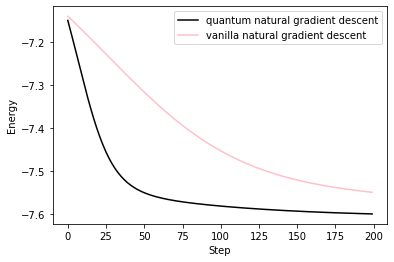

In [14]:
from matplotlib import pyplot as plt
plt.plot(QNG_cost, "black", label="quantum natural gradient descent")
plt.plot(vanilla_cost, "pink", label="vanilla natural gradient descent")

plt.ylabel("Energy")
plt.xlabel("Step")
plt.legend()
plt.show()